# fbb scheleton notebook for PUI2016 HW6

In [165]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json
import seaborn
import statsmodels.api as sm
import statsmodels.formula.api as smf
np.random.seed(123)

#s = json.load( open(os.getenv('PUI2016')+'/fbb_matplotlibrc.json') )
#pl.rcParams.update(s)
if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['xlim', 'ylim']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


## An interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". For example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
## So let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

## Either obtain the data through the API or download the csv file, and move it to $PUIDATA

## However this datasets does not have the number of units. We can find that in the Pluto dataset.

## Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [66]:
#download, and move data to PUIDATA, and read data in 
nrg = pd.read_csv(os.getenv("PUIDATA") + "/" + "Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")

if not os.path.isfile(os.getenv('PUIDATA') + '/Manhattan/MNMapPLUTO.shp'):
    outf = os.getenv('PUIDATA') + '/mnmanp.zip'
    os.system('curl -o ' + outf + ' https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip')
    os.system('unzip ' + outf + ' -d ' + os.getenv('PUIDATA') + '/Manhattan/')
    os.system('rm ' + outf)

bsize_raw = gp.read_file(os.getenv('PUIDATA') + '/Manhattan/MNMapPLUTO.shp')

In [67]:
nrg.columns

Index([u'Record Number', u'NYC Borough, Block, and Lot (BBL)',
       u'Co-reported BBL Status', u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')

In [71]:
bsize_raw.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

In [73]:
bsize_raw.head()

,APPBBL,APPDate,Address,AllZoning1,AllZoning2,AreaSource,AssessLand,AssessTot,BBL,BldgArea,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
0,0.000000e+00,None,1592 2 AVENUE,C1-9/TA,None,2,468000.0,1435950.0,1.015450e+09,10885,...,0,1920,None,10028,C1-9,None,None,None,9a,"POLYGON ((997277.2344000041 221816.0936000049,..."
1,1.007230e+09,11/30/2006,263 9 AVENUE,C1-5/R8,None,2,539984.0,11879993.0,1.007238e+09,89203,...,0,1914,None,10001,R8,None,None,None,8d,"POLYGON ((984164.5626000017 211846.0703999996,..."
2,0.000000e+00,None,310 EAST 109 STREET,R7A,None,2,140102.0,343271.0,1.016800e+09,12000,...,0,1910,None,10029,R7A,None,None,None,6b,"POLYGON ((1000742.195800006 227910.6640000045,..."
3,0.000000e+00,None,720 PARK AVENUE,R10/PI/LH-1A,R8B,2,5040000.0,30591900.0,1.013850e+09,203490,...,2006,1928,None,10021,R10,R8B,None,None,8c,"POLYGON ((994007.6886000037 219880.428399995, ..."
4,0.000000e+00,None,3 WEST 83 STREET,R8B,R10A,2,437850.0,1267200.0,1.011970e+09,13839,...,0,1900,None,10024,R8B,R10A,None,None,5d,"POLYGON ((992273.6850000024 224863.4904000014,..."


In [22]:
# make sure you clean up your data and throw away columns you do not need!
nrg.head()

,Record Number,"NYC Borough, Block, and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,NaN,Not Available,NaN,NaN,NaN,918919,NaN,Office,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,Yes,None,NaN,NaN,NaN,NaN,NaN,82730.0,NaN,1.0
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,NaN,Not Available,NaN,NaN,NaN,64200,NaN,Multifamily Housing,NaN
3,12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,...,No,None,NaN,NaN,NaN,NaN,NaN,440360.0,NaN,1.0
4,15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,...,NaN,None,Not Available,NaN,NaN,NaN,50000,NaN,Multifamily Housing,NaN


In [141]:
#dropping some data I no longer need
nrg_small = nrg[['NYC Borough, Block, and Lot (BBL)', 'Borough', 'Total GHG Emissions(MtCO2e)', \
                 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)', \
                 'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)']]
nrg_small.columns = ['BBL', 'Borough', 'GHG_Emissions', 'Site_EUI', 'Floor_area', 'water_amt']
nrg_small.head()

,BBL,Borough,GHG_Emissions,Site_EUI,Floor_area,water_amt
0,1.000410e+09,Manhattan,NaN,NaN,918919,Not Available
1,4.021460e+09,Queens,NaN,NaN,NaN,NaN
2,2.027620e+09,Bronx,NaN,NaN,64200,Not Available
3,1.006700e+09,Manhattan,NaN,NaN,NaN,NaN
4,2.048300e+09,Bronx,NaN,NaN,50000,Not Available


In [136]:
#dropping data for bsize
bsize = bsize_raw[['BBL', 'BldgArea', ]]

In [142]:
print(len(nrg), len(nrg_small))
print(nrg_small.dtypes)
nrg_small.head()

16170 16170
BBL              float64
Borough           object
GHG_Emissions     object
Site_EUI          object
Floor_area        object
water_amt         object
dtype: object


,BBL,Borough,GHG_Emissions,Site_EUI,Floor_area,water_amt
0,1.000410e+09,Manhattan,NaN,NaN,918919,Not Available
1,4.021460e+09,Queens,NaN,NaN,NaN,NaN
2,2.027620e+09,Bronx,NaN,NaN,64200,Not Available
3,1.006700e+09,Manhattan,NaN,NaN,NaN,NaN
4,2.048300e+09,Bronx,NaN,NaN,50000,Not Available


In [137]:
# dropping NaN values for bsize
#bsize = bsize[bsize.BldgArea.notnull()]
print(len(bsize_raw), len(bsize))
bsize.head()

42697 42697


,BBL,BldgArea,UnitsRes,UnitsTotal
0,1.015450e+09,10885,16,18
1,1.007238e+09,89203,50,50
2,1.016800e+09,12000,10,10
3,1.013850e+09,203490,29,32
4,1.011970e+09,13839,26,26


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f60fc426990>]], dtype=object)

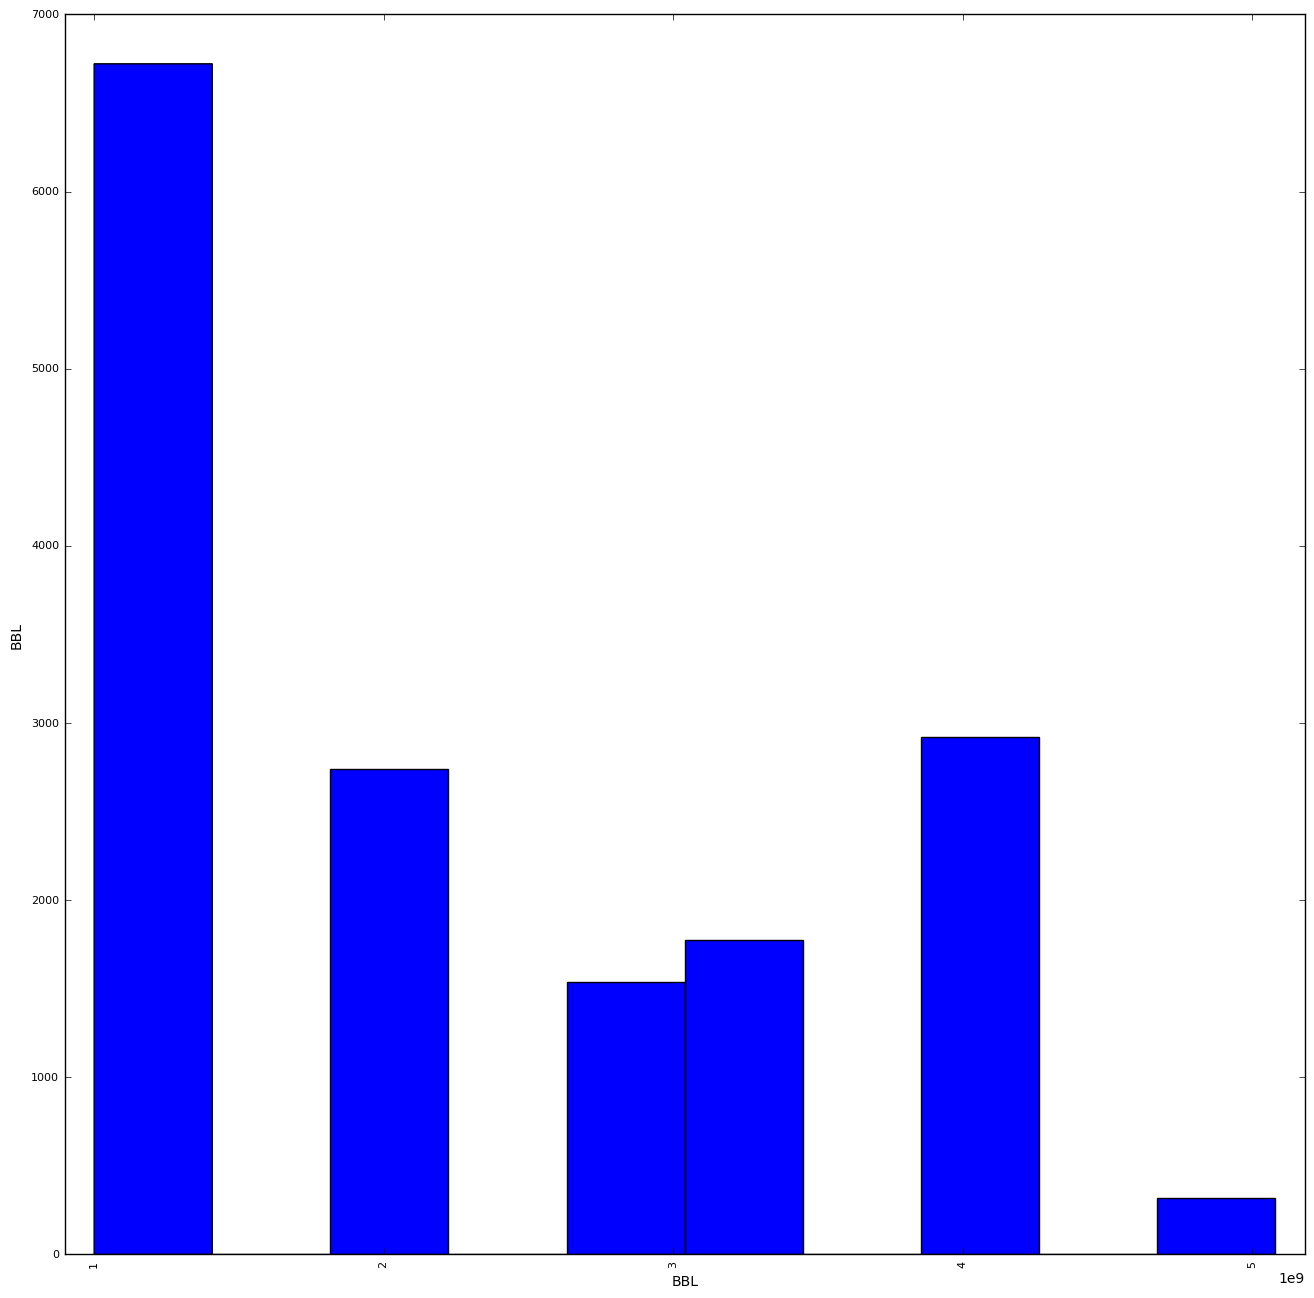

In [143]:
#try make a scatter plot of nrg. Few columns will plot
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg_small, s=300, figsize=(16, 16))

Figure 1: scatter matrix of all numerical values in the files.

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them.
Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into.
This has to be done entry by entry: if you give it a series you get error "cannot convert the series to..."
However you can pass it a whole array by using it in conjunction with np.vectorize (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.

In [119]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False
        


Now for every column I care about I can create an array, call it for eg. indx, of True and False (a Boolean array) that i can use as an index to pick entries that I want to use from my arrays of interest. 

I can replace the entries that failed to be converted to 'NaN'
(because my function return Trues when I can convert and False otherwise i actuallly want the complementary array: ~indx) 

In [144]:
#example
columns2convert = ['GHG_Emissions', 'Site_EUI', 'Floor_area', 'water_amt']
 
for i in columns2convert:
    indx = (np.vectorize(canconvert)(nrg_small[i]))
    nrg_small[i][~indx] = float('NaN')

print(nrg_small.dtypes)
nrg_small.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


BBL              float64
Borough           object
GHG_Emissions     object
Site_EUI          object
Floor_area        object
water_amt         object
dtype: object


,BBL,Borough,GHG_Emissions,Site_EUI,Floor_area,water_amt
0,1.000410e+09,Manhattan,NaN,NaN,918919,NaN
1,4.021460e+09,Queens,NaN,NaN,NaN,NaN
2,2.027620e+09,Bronx,NaN,NaN,64200,NaN
3,1.006700e+09,Manhattan,NaN,NaN,NaN,NaN
4,2.048300e+09,Bronx,NaN,NaN,50000,NaN


In [145]:
nrg_small['totalEnergy'] = nrg_small.Site_EUI.astype(float) * nrg_small.Floor_area.astype(float)
nrg_small.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,BBL,Borough,GHG_Emissions,Site_EUI,Floor_area,water_amt,totalEnergy
0,1.000410e+09,Manhattan,NaN,NaN,918919,NaN,NaN
1,4.021460e+09,Queens,NaN,NaN,NaN,NaN,NaN
2,2.027620e+09,Bronx,NaN,NaN,64200,NaN,NaN
3,1.006700e+09,Manhattan,NaN,NaN,NaN,NaN,NaN
4,2.048300e+09,Bronx,NaN,NaN,50000,NaN,NaN


In [123]:
##check that your conversion worked: e.g.
#print (nrg_small['Site_EUI'].astype(float))

for i in columns2convert:
    print(nrg_small[i].astype(float))
#[...] check all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
#print(bsize.BBL.astype(float))
#this should not return an error
#notice i can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!


0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12          NaN
13          NaN
14          NaN
15          NaN
16       3556.4
17          NaN
18          NaN
19          NaN
20          NaN
21          NaN
22          NaN
23          NaN
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
          ...  
16140       NaN
16141       NaN
16142       NaN
16143       NaN
16144       NaN
16145       NaN
16146       NaN
16147       NaN
16148       NaN
16149       NaN
16150       NaN
16151       NaN
16152       NaN
16153       NaN
16154       NaN
16155       NaN
16156       NaN
16157       NaN
16158       NaN
16159       NaN
16160       NaN
16161       NaN
16162       NaN
16163       NaN
16164       NaN
16165       NaN
16166       NaN
16167       NaN
16168       NaN
16169       NaN
Name: GHG_Emissions, dty

# MERGE THE DATASET
TO DO IT WE NEED A COMMON COLUMN: the building id BBL However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f610d766e90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f60f6416390>]], dtype=object)

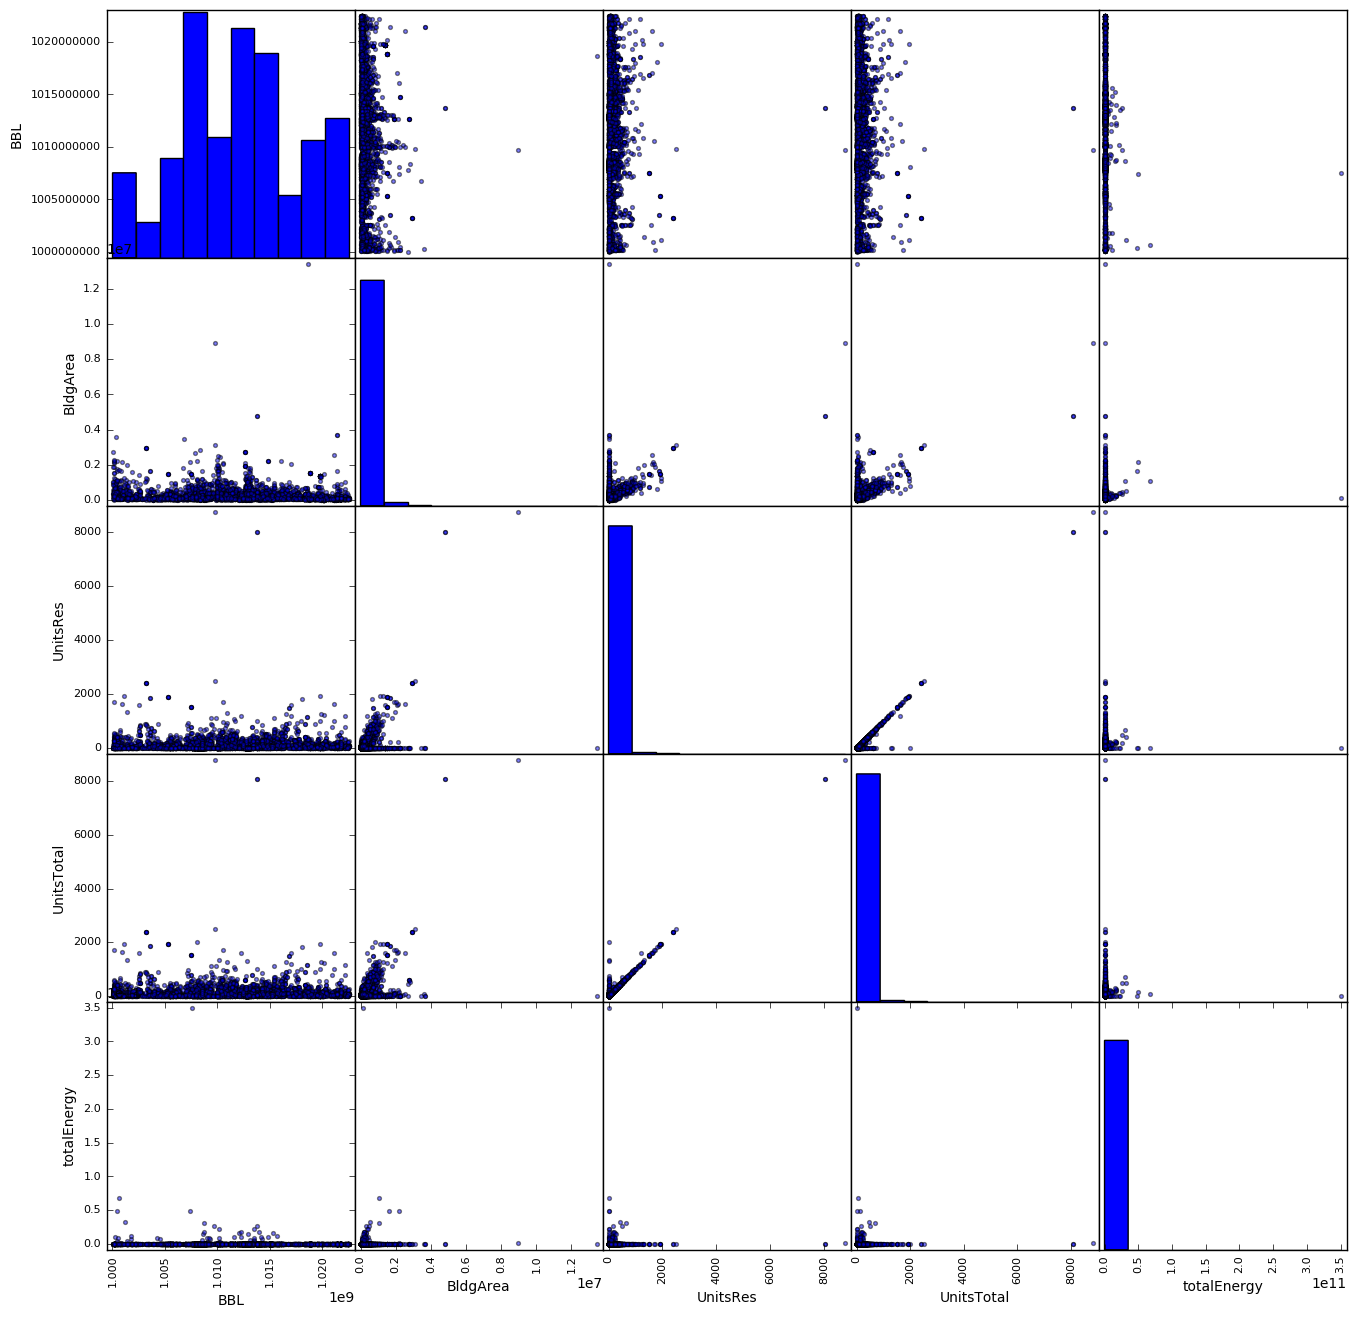

In [146]:
# prepare your BBL columns
#nrg_small.rename...
#merge
bblnrgdata = bsize.merge(nrg_small, on=['BBL'])

# Now the scatter matrix plot should show more columns.
scatter_matrix (bblnrgdata, s=30, figsize=(16, 16))

once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building. Remember: **Energy TOTAL, not per sq ft...** Here you can choose what you think makes more sense for the number of units: all units, residential units... 

**Make a  scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. **


Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

I left my plots below as guidance. **Remember, each plot needs a descriptive caption, and axis labels**

In [147]:
bblnrgdata.head()

,BBL,BldgArea,UnitsRes,UnitsTotal,Borough,GHG_Emissions,Site_EUI,Floor_area,water_amt,totalEnergy
0,1.007238e+09,89203,50,50,Manhattan,439.4,68.7,95844,NaN,6584482.8
1,1.013850e+09,203490,29,32,Manhattan,1562.5,87.4,206989,NaN,18090838.6
2,1.021740e+09,52920,72,72,Manhattan,555.9,140.4,52920,233.77,7429968.0
3,1.008830e+09,98359,107,108,Manhattan,723.8,96.5,98359,NaN,9491643.5
4,1.008570e+09,140000,134,138,Manhattan,456.2,36.4,154000,32.92,5605600.0


In [148]:
bblnrgdata.dtypes

BBL              float64
BldgArea           int64
UnitsRes           int64
UnitsTotal         int64
Borough           object
GHG_Emissions     object
Site_EUI          object
Floor_area        object
water_amt         object
totalEnergy      float64
dtype: object

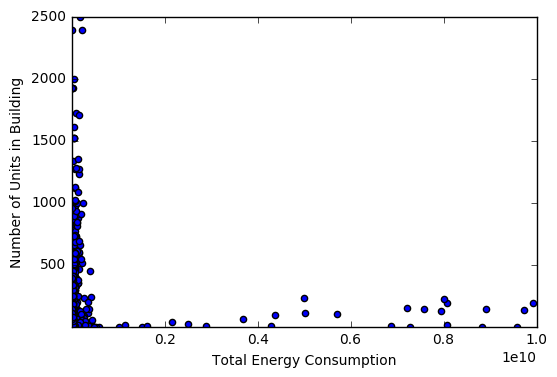

In [154]:
# first scatter plot
# plot total energy consumption vs number of units in building
pl.scatter(bblnrgdata.totalEnergy, bblnrgdata.UnitsTotal)
pl.xlim(1000, 1e10)
pl.ylim(1, 2500)
plt.xlabel('Total Energy Consumption (kBtu)')
plt.ylabel('Number of Units in Building')

The scatterplot above shows the correlation between total energy consumption (in kBtus) vs the number of units in the building

when the points in a plot all look scrunched against the axis 

**Try to make a log plot instead**. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

Also I removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.



In [227]:
#remove outlier / zeros first
bblnrgdata_cut = bblnrgdata[bblnrgdata['totalEnergy'] > 1000]
bblnrgdata_cut = bblnrgdata_cut[bblnrgdata_cut['UnitsTotal'] > 1]
bblnrgdata_cut = bblnrgdata_cut[bblnrgdata_cut['UnitsTotal'] < 2000]


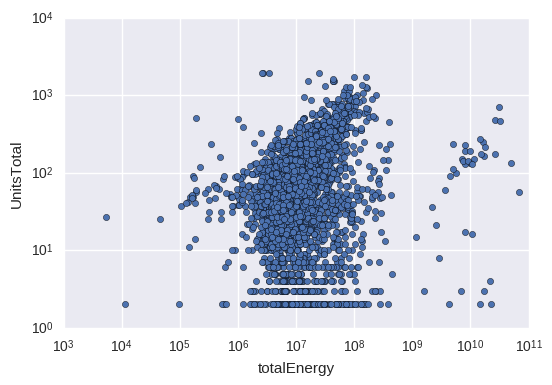

In [228]:
#log plot
bblnrgdata_cut.plot(x = 'totalEnergy', y = 'UnitsTotal', kind = 'scatter', loglog=True)

The plot above is a scatterplot on a log scale of Total Energy vs the Number of Units in a Building.

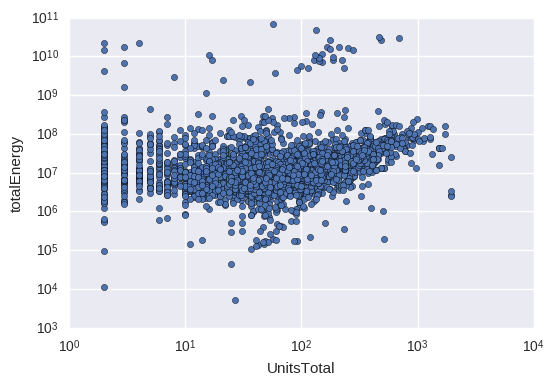

In [229]:
bblnrgdata_cut.plot(x = 'UnitsTotal', y = 'totalEnergy', kind = 'scatter', loglog=True)

The plot above is a scatterplot on a log scale of Number of Units in a Building vs the total energy used.

Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

## BUT REMEMBER: we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:
if you used statsmodels it would look something like this:


In [230]:
X = sm.add_constant(np.log10(x))
linmodel = sm.OLS(np.log10(y), X, missing='drop').fit() # ignores entires 
                                                     # where x or y is NaN

NameError: name 'x' is not defined

## choose wisely which is your DEPENDENT and which is your INDEPENDENT variable. 
both for what you want to do logically (what changes as a functino of what) but also based on which variable has a 'sensible' distribution that allows you to fit a function to it: **you need your independent variable to span a large range, and to be spread somewhat evenly in the range, rather than just clustered in a spot** so in this case switching the independent and dependent variable may be a good idea.



1. **Fit a line** to Units vs Energy.
2. **Fit a line** to Energy vs Units.
3. **Evaluate which is better by calculating the chi square**. I provide a function for that or you can write your own. *Assume poisson statistics for the errors on the independent variable*. 
    The function is 
    
    chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$
    
    where the sum is over all datapoints, 
    
    for the i-th value with x value $x_i$ model is the predction of your fit for $x_i$, 
    
    $data(x_i)$ 
    is your observation, 
    
    and $error_i$ is $\sqrt{data(x_i)}$
    (but remember you worked in log space! What are the proper errors??)
    
4. **Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2+bx+c$ .

5. **Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**. The formula is:
    
    LR  =  -2 * (logLikelihood_Model1 - logLikelihood_Model2)
    
    where Model1 is the least complex (fewer parameters).
    
    Th logLikelihood can be extracted from the model summary when using statsmodels.
    
    Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if *at alpha = 0.05* Model1 is preferible to Model2. The LR is chi^2 distributed with number of degrees of freedom N_{DOF} = parameters_Model2 - parameters_Model1
    
    
    Also if you used statsmodels for the fit you can use the 
    compare_lr_test() method of your fit and verify you got the right answer.  Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit 
    (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))



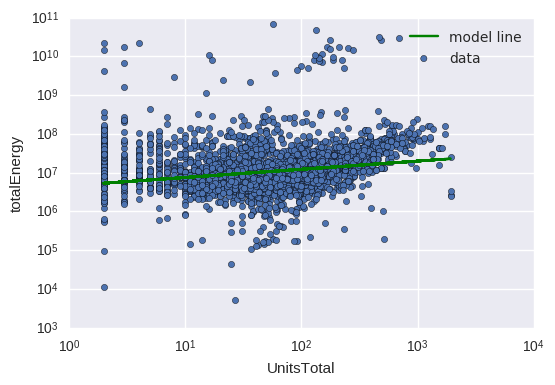

In [231]:
# fits and plots here
# your plots should show datapoints (as scatter plot) and models (as lines)

##1. units vs energy
X = sm.add_constant(np.log10(bblnrgdata_cut.UnitsTotal))
linmodel = sm.OLS(np.log10(bblnrgdata_cut.totalEnergy), X, missing='drop').fit() # ignores entires 
                                                     # where x or y is NaN
    
ax = bblnrgdata_cut.plot(x = 'UnitsTotal', y = 'totalEnergy', kind = 'scatter', loglog=True, label='data')
ax.plot(bblnrgdata_cut['UnitsTotal'], 10**(linmodel.predict()), c='g', label='model line')
ax.legend()

The plot above shows log-scale apartment unit count vs log-scale total energy usage, with a regression line fitted with apartment unit count as the dependent variable and total energy usage as the independent variable.

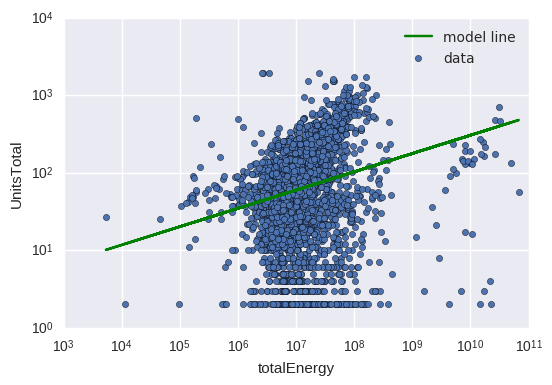

In [232]:
##2. energy vs units

X = sm.add_constant(np.log10(bblnrgdata_cut.totalEnergy))
linmodel_2 = sm.OLS(np.log10(bblnrgdata_cut.UnitsTotal), X, missing='drop').fit() # ignores entires 
                                                     # where x or y is NaN
    
ax = bblnrgdata_cut.plot(x = 'totalEnergy', y = 'UnitsTotal', kind = 'scatter', loglog=True, label='data')
ax.plot(bblnrgdata_cut['totalEnergy'], 10**(linmodel_2.predict()), c='g', label='model line')
ax.legend()

The plot above shows log-scale total energy usage vs log-scale apartment unit count, with a regression line fitted with apartment unit count as the independent variable and total energy usage as the dependent variable.

In [233]:
# my OLS summary. 
# Yours may be somewhat different depending on how you cut the data
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            totalEnergy   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     244.4
Date:                Mon, 17 Oct 2016   Prob (F-statistic):           9.95e-54
Time:                        00:42:57   Log-Likelihood:                -3302.6
No. Observations:                4654   AIC:                             6609.
Df Residuals:                    4652   BIC:                             6622.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.6664      0.025    264.257      0.000         6.617     6.716
UnitsTotal     0.2115      0.014     15.633      0.000         0.185     0.238
==============================================================================
Omnibus:                     2210.211   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31823.170
Skew:                           1.896   Prob(JB):                         0.00
Kurtosis:                      15.237   Cond. No.                         8.28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [234]:
bblnrgdata_cut['totalEnergy_predict']=(linmodel.predict())
bblnrgdata_cut['UnitsTotal_predict']=(linmodel_2.predict())
bblnrgdata_cut['totalEnergy_log10']=np.log10(bblnrgdata_cut['totalEnergy'])
bblnrgdata_cut['UnitsTotal_log10']=np.log10(bblnrgdata_cut['UnitsTotal'])
bblnrgdata_cut.head()

,BBL,BldgArea,UnitsRes,UnitsTotal,Borough,GHG_Emissions,Site_EUI,Floor_area,water_amt,totalEnergy,totalEnergy_predict,UnitsTotal_predict,totalEnergy_log10,UnitsTotal_log10
0,1.007238e+09,89203,50,50,Manhattan,439.4,68.7,95844,NaN,6584482.8,7.025753,1.733437,6.818522,1.698970
1,1.013850e+09,203490,29,32,Manhattan,1562.5,87.4,206989,NaN,18090838.6,6.984759,1.837015,7.257459,1.505150
2,1.021740e+09,52920,72,72,Manhattan,555.9,140.4,52920,233.77,7429968.0,7.059247,1.745817,6.870987,1.857332
3,1.008830e+09,98359,107,108,Manhattan,723.8,96.5,98359,NaN,9491643.5,7.096492,1.770914,6.977341,2.033424
4,1.008570e+09,140000,134,138,Manhattan,456.2,36.4,154000,32.92,5605600.0,7.119007,1.716942,6.748622,2.139879


In [235]:
##3. Compare Chi-squared test stats for #1 and #2
bblnrgdata_cut['chi_sq_linmodel_i'] = (bblnrgdata_cut['totalEnergy_predict']-bblnrgdata_cut['totalEnergy_log10']) ** 2 / \
bblnrgdata_cut['totalEnergy_log10']
    
bblnrgdata_cut['chi_sq_linmodel_2_i'] = (bblnrgdata_cut['UnitsTotal_predict']-bblnrgdata_cut['UnitsTotal_log10']) ** 2 / \
bblnrgdata_cut['UnitsTotal_log10']

print(bblnrgdata_cut['chi_sq_linmodel_i'].sum())
print(bblnrgdata_cut['chi_sq_linmodel_2_i'].sum())
bblnrgdata_cut.head()

149.073757385
1845.48622086


,BBL,BldgArea,UnitsRes,UnitsTotal,Borough,GHG_Emissions,Site_EUI,Floor_area,water_amt,totalEnergy,totalEnergy_predict,UnitsTotal_predict,totalEnergy_log10,UnitsTotal_log10,chi_sq_linmodel_i,chi_sq_linmodel_2_i
0,1.007238e+09,89203,50,50,Manhattan,439.4,68.7,95844,NaN,6584482.8,7.025753,1.733437,6.818522,1.698970,0.006298,0.000699
1,1.013850e+09,203490,29,32,Manhattan,1562.5,87.4,206989,NaN,18090838.6,6.984759,1.837015,7.257459,1.505150,0.010247,0.073172
2,1.021740e+09,52920,72,72,Manhattan,555.9,140.4,52920,233.77,7429968.0,7.059247,1.745817,6.870987,1.857332,0.005158,0.006695
3,1.008830e+09,98359,107,108,Manhattan,723.8,96.5,98359,NaN,9491643.5,7.096492,1.770914,6.977341,2.033424,0.002035,0.033889
4,1.008570e+09,140000,134,138,Manhattan,456.2,36.4,154000,32.92,5605600.0,7.119007,1.716942,6.748622,2.139879,0.020328,0.083591


In [236]:
bblnrgdata_cut.sort('chi_sq_linmodel_2_i')

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,BBL,BldgArea,UnitsRes,UnitsTotal,Borough,GHG_Emissions,Site_EUI,Floor_area,water_amt,totalEnergy,totalEnergy_predict,UnitsTotal_predict,totalEnergy_log10,UnitsTotal_log10,chi_sq_linmodel_i,chi_sq_linmodel_2_i
3968,1.001010e+09,111685,41,51,Manhattan,315.8,45.8,111685,NaN,5.115173e+06,7.027572,1.707559,6.708860,1.707570,0.015141,6.855261e-11
433,1.016550e+09,52520,48,48,Manhattan,235.9,75.7,52250,NaN,3.955325e+06,7.022003,1.681206,6.597182,1.681241,0.027356,7.393651e-10
5877,1.018880e+09,119315,57,57,Manhattan,618,68.599999999999994,119315,NaN,8.185009e+06,7.037789,1.755736,6.913019,1.755875,0.002252,1.098632e-08
123,1.010080e+09,54838,52,55,Manhattan,522.5,131.1,53837,NaN,7.058031e+06,7.034508,1.740554,6.848684,1.740363,0.005042,2.109504e-08
3260,1.010250e+09,134441,0,59,Manhattan,732.2,76.3,124728,54.32,9.516746e+06,7.040956,1.771185,6.978488,1.770852,0.000559,6.267643e-08
3775,1.011620e+09,68989,53,53,Manhattan,461.3,84.4,71749,29.07,6.055616e+06,7.031105,1.724856,6.782158,1.724276,0.009138,1.951353e-07
3992,1.021790e+09,58008,61,62,Manhattan,877.7,200.6,58008,53.3,1.163640e+07,7.045512,1.791793,7.065819,1.792392,0.000058,1.999493e-07
6159,1.021790e+09,52446,53,53,Manhattan,452.9,108.7,55068,55.94,5.985892e+06,7.031105,1.723669,6.777129,1.724276,0.009518,2.135232e-07
2441,1.020020e+09,60450,44,55,Manhattan,526.79999999999995,115.3,60682,NaN,6.996635e+06,7.034508,1.739659,6.844889,1.740363,0.005253,2.845909e-07
5966,1.021800e+09,51138,48,48,Manhattan,301.5,77.900000000000006,51138,38.06,3.983650e+06,7.022003,1.681937,6.600281,1.681241,0.026946,2.881617e-07


In [237]:
##4. Fit a 2nd degree polynomial to units v energy
bblnrgdata_cut['UnitsTotal_2'] = bblnrgdata_cut['UnitsTotal'] ** 2
bblnrgdata_cut.head()


,BBL,BldgArea,UnitsRes,UnitsTotal,Borough,GHG_Emissions,Site_EUI,Floor_area,water_amt,totalEnergy,totalEnergy_predict,UnitsTotal_predict,totalEnergy_log10,UnitsTotal_log10,chi_sq_linmodel_i,chi_sq_linmodel_2_i,UnitsTotal_2
0,1.007238e+09,89203,50,50,Manhattan,439.4,68.7,95844,NaN,6584482.8,7.025753,1.733437,6.818522,1.698970,0.006298,0.000699,2500
1,1.013850e+09,203490,29,32,Manhattan,1562.5,87.4,206989,NaN,18090838.6,6.984759,1.837015,7.257459,1.505150,0.010247,0.073172,1024
2,1.021740e+09,52920,72,72,Manhattan,555.9,140.4,52920,233.77,7429968.0,7.059247,1.745817,6.870987,1.857332,0.005158,0.006695,5184
3,1.008830e+09,98359,107,108,Manhattan,723.8,96.5,98359,NaN,9491643.5,7.096492,1.770914,6.977341,2.033424,0.002035,0.033889,11664
4,1.008570e+09,140000,134,138,Manhattan,456.2,36.4,154000,32.92,5605600.0,7.119007,1.716942,6.748622,2.139879,0.020328,0.083591,19044


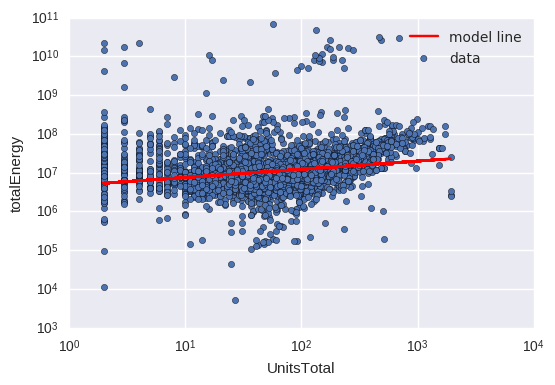

In [238]:
linmodel_3 = smf.ols(formula = 'np.log10(totalEnergy) ~ np.log10(UnitsTotal) + np.log10(UnitsTotal_2)',
                     data=bblnrgdata_cut).fit()


ax = bblnrgdata_cut.plot(x = 'UnitsTotal', y = 'totalEnergy', kind = 'scatter', loglog=True, label='data')
ax.plot(bblnrgdata_cut['UnitsTotal'], 10**(linmodel_3.predict()), c='r', label='model line')
ax.legend()    


In [239]:
##5. Compare Units v Energy (#1) with Units v Energy (2nd order) (#4) with Likelihood ratio test

print ("LR : ", -2 * (-linmodel.llf - (-linmodel_3.llf)))
print ("LR from statsmodels:", linmodel_3.compare_lr_test(linmodel))

LR :  -9.09494701773e-13
LR from statsmodels: (9.0949470177292824e-13, nan, 0.0)


There does not seem to be a difference between Units v Energy and Units v Energy (with a 2nd degree polynomial Units term added)

## Extra credit 1: calculate and plot the likelihood surface
Create a function that minimizes the residuals:

the residuals are the sum of the differences between data and model: in the case of a line fit model. Use the same function you created for the chi^2 test.

You should sum over each datapoints the residuals squared, which should look something like

(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2 / errors^2

where a and b are the parameters returned by the line fitter. 

For each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope.


You can write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


Lsurface = np.zeros((len(A), len(B)))
for i,a in enumerate(A):
    for j,b in enumerate(B):
         Lsurface[i][j] = np.nansum(residuals(a,b,data,errors)) .....

this gives you a 2D array that represents your likelihood surface! What we do to find a good fit is find the minimum (lowest point) on this surface.
You can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap" but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface)). Also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. Inputting your data in the cell below should give a plot similar to mine

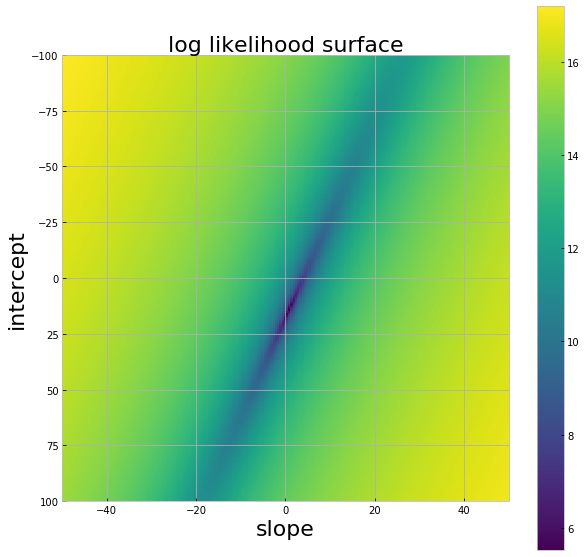

In [42]:
pl.figure(figsize=(10,10))
pl.title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(Lsurface), extent = [-50,50,100,-100], aspect=0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.colorbar()

## EXTRA CREDIT: get creative with the dataset. can you make an insigntful plot to show any structure in the data?

below I am mapping the building age to a colormap and the ratio of total to residential units to the size of the datapoint.

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Text(0.5,0,'total energy consumption (kBtu)')

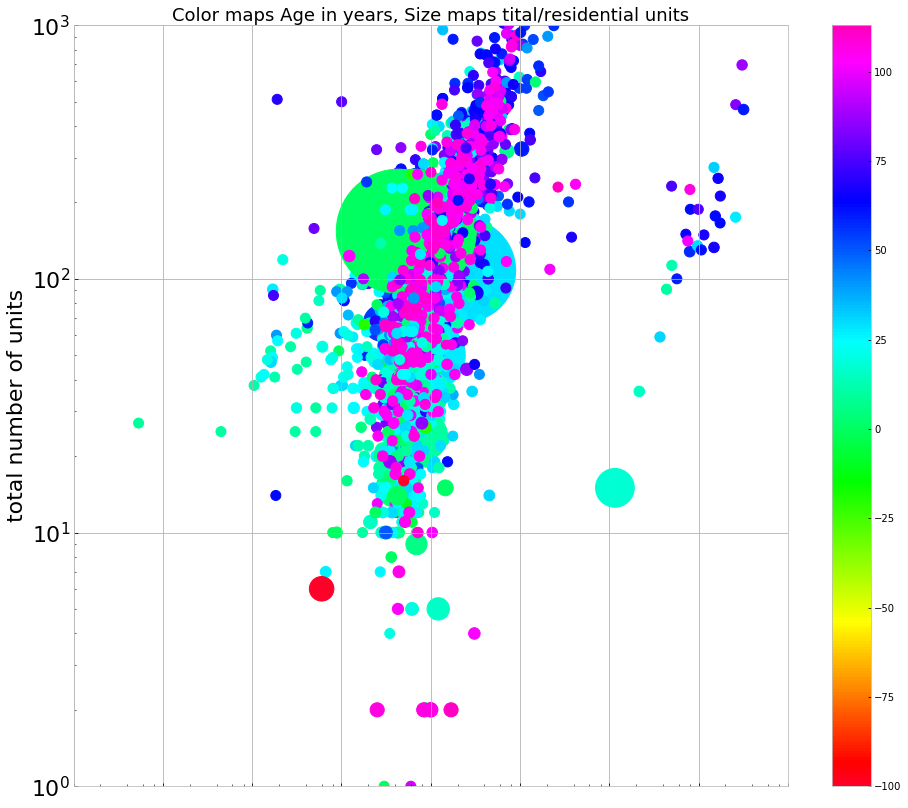

In [49]:
bblnrgdata['YearBuilt'][bblnrgdata['YearBuilt']<1800]=1800

bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', 
                fontsize=22, colormap='gist_rainbow', alpha = 1, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), 
                c=bblnrgdata['YearBuilt']-1900, 
                s=bblnrgdata['UnitsTotal']/bblnrgdata['UnitsRes']*100)
pl.title('Color maps Age in years, Size maps tital/residential units', fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22)